# Enhanced Compressive Threshold Quantum State Tomography for Qudits.

Enhanced Compressive Threshold Quantum State Tomography (ECT-QST) is a procedure enabling quantum state tomography of systems of qudits while optimizing the number of **measurement settings** to be used. It is based on ideas from [threshold quantum state tomography (tQST)](https://doi.org/10.1063/5.0219143), which is a procedure that performs quantum state tomography optimizing the number of **projective measurements**.

This notebook illustrates ECT-QST, by showing how to perform it for $N$ a qu$d$it systems using our python library, namely the classes ``ECTtomography`` and ``Maximum_likelihood_tomography``. This example assumes noiseless synthetic data, and uses ``numpy`` arrays as the main data container.

The main files of the distribution are imported as
```
import density_matrix_tool as dmt
import ect_tomography_qudit as ect
import maximum_likelihood as ml
```
 * ``dmt`` contains general routines to deal with matrices (_e.g._, calculation of fidelities, generation of certain type of matrices)
 * ``ect`` contains routines the are related to ECT-QST (_e.g._, computing the measurement settings that will be measured)
 * ``ml`` contains routines that perform maximum likelihood reconstruction of the density matrix given the measurements.

Analogously to tQST, ECT-QST proceeds by the following steps:

## Instantiation of the ``ECTtomography`` class.

One needs to specify the dimension $d$ of the qudits and their number $N$.
```
d = 3
N = 2
tomo = ect.ECTtomography(d,N, verbose=True)
```
where the ``verbose`` flag results in informative output on the various steps.

## Measurement of the diagonal of the the density operator

The first step is to perform a measurement of the system in the computational basis.   
For $d=2$ this is the setting that measures the $\sigma_z$ [Pauli matrix](https://en.wikipedia.org/wiki/Pauli_matrices) on all the qubits. In the general case, the computational basis is defined here as the set of common eigenstates of the maximum abelian subspace of $SU(d)$ operators on each qubit.   
For $d=3$, the computational basis is defined as the common eigenstates of the $\lambda_3$ and $\lambda_8$ [Gell-Mann matrices](https://en.wikipedia.org/wiki/Gell-Mann_matrices).

In any case, the vectors representing the states that measure the diagonal element of the density matrix are the rows of the $(d^N, d^N)$ identity matrix. Once the corresponding measurement values are placed is a numpy array, let's call it ``diagonal``, one needs to decide the value of a threshold ``t``, that indicates which are the states of the computational basis the provide significant information.    
If ``t = np.min(diagonal)``, then complete quantum state tomography will be performed.

The choice of the threshold is crucial: ideally, it is larger than the values of the diagonal that correspond to "noise" and smaller than the values of the diagonal elements that correspond to "signal". In case of doubt, ``dmt.gini_index(diagonal)`` will return an estimate of the threshold based on the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient).

### Important notice

The elements of ``diagonal`` need not to be normalized to one, but the threshold ``t`` and all subsequent counts **must** be given with the same normalization.

## Finding the settings to be measured

The ECT tomography algorithm is based on finding the settings whose projectors give the largest information on the real and imaginary part of the matrix elements to be further determined. These settings come with a weight that estimates the importance of their contribution.   
These are found by calling
```
settings, weights = tomo.ECT_settings(diagonal, t)
```

On outputs, `weight` is an numpy array with the weights, and ``settings`` is a list of $N$ strings, denoting which setting to measure on the various qubit. Settings are identified using the following notation
* `Z` denotes any element of the maximum abelian subspace. For a qubit, this would be $\sigma_z$. For a qutrit, either $\lambda_3$ or $\lambda_8$.
* `Rn.m` is the $d \times d$ matrix which has all zeros, except a single $1$ in position $(n,m)$ and $(m,n)$. For a qubit, the only possibility is `R0.1` which is $\sigma_x$. For a qutrit there are three possibilities; for example ``R0.2`` is the $\lambda_4$  [Gell-Mann matrix](https://en.wikipedia.org/wiki/Gell-Mann_matrices).
* `In.m` is the $d \times d$ matrix which has all zeros, except a single $i$ in position $(n,m)$ and a corresponding $-i$ in position $(m,n)$. For a qudit, this is $\sigma_y$. For a qutrit there are again three possibilities; for example ``I1.2`` is the $\lambda_7$ [Gell-Mann matrix](https://en.wikipedia.org/wiki/Gell-Mann_matrices).

The list of ``settings`` is ordered by decreasing weight. It is therefore recommended to begin measurements from the first onward.

### Measuring a setting

Each setting provides $d^N$ projector operators, each of which need to be further measured.
The method ``tomo.projector_names_of_setting(s)`` provides a list of identifiers. Each identifier is, in turn, a list of names of single-qudit projector, with the following notation:

* `Zn.n`, the $n$th computational basis state, that is a $d$-dimensional vector that is all zeros except $1$ at position $n$.
* `Xn.m` or `xn.m`. These are the eigenvectors with eingevalues $1$ and $-1$ of ``Rn.m``, respectively.
* `Yn.m` or `yn.m`. These are the eigenvectors with eingevalues $1$ and $-1$ of ``In.m``, respectively.

The actual projector in $d^N$ is the Korenecker product of these single-qudit projectors, and can be obtained by ``tomo.projector_from_name(name)``.

In the $d=2$ case the method prints also the projector names with the usual notation, if the class is instantiated with ``verbose=True``.

## Performing the maximum likelihood reconstruction

Maximum likelihood reconstruction is performed by a class instantiated as
```
maxlik = ml.Maximum_likelihood_tomography([d]*N)
```

One needs to pass to it the states measured $|\phi_k\rangle$ and the corresponding counts $c_k = \langle \phi_k | \rho | \phi_k \rangle$.

States are passed as a $(M, d^N)$ numpy array ``V``, where $M$ is the number of measurements. Hence, the states are the rows of the array $V$. The corresponding counts are passed as a $M$-dimensional numpy array ``C``.

This is done using the method ``maxlik.set_counts(V,C)``.

After this, one can optimize the likelihood by calling ``maxlik.minimize_pool_mt(T)``. This performs ``T`` local optimizations in parallel. The reconstructed density matrix can then be obtained by
```
reconstructed_rho = maxlik.model_density_matrix()
```

There are several models that one can use for the density matrix. The most unbiased is to write it as $\rho = T T^\dagger$, where $T$ is a triangular matrix. Given the large number of parameters of $T$ (=$d^N$), this optimization is by far the most time consuming, but should be reasonably fast for small values of $d$ and $N$.

Another model writes $\rho = M M^\dagger$, where $M$ is a $(d^N, m)$ matrix (with $m \ll d^N$). The rationale is that $m$ is of the order of the rank expected for $\rho$. The validity of this approximation can be checked by verifying that $\mathrm{tr}(\rho^2) m \gg 1$.    
This model is requested by instantiating
```
maxlik = ml.Maximum_likelihood_tomography([d]*N, model=ml.model_g5, model_params=M)
```

### Projectors and counts

Let us assume that one has a list ``L`` of projectors names that have been measured (this list **must** include the computational basis, that is the initial diagonal measurement), and a list ``c`` of the corresponding counts.
The arrays ``V`` and ``C`` can be generated as
```
V = np.array([tomo.projector_of_name(x) for x in L])
C = np.array(c)
```

## Recovery of the original tQST method

The ``ECTtomography`` class contains a method to recover projectors implementing the original [tQST approach](https://doi.org/10.1063/5.0219143).
Although these projectors do not turn out always to be the same, they nevertheless enable a reconstruction of the density matrix with the same quality.

The projectors are obtained using the method 
```
projs, names = tomo.tQST_projectors(diagonal, t)
```
where ``projs`` are $d^N$-dimensional numpy arrays. The names of the projectors follow the same notation described before.

In the $d=2$ case the method prints also the projector names with the usual notation, if the class is instantiated with ``verbose=True``.

In the following, we provide 4 examples on how to use the ``ECTtomography`` class.

In [1]:
import numpy as np

In [1]:
import sys
sys.path.append("../")

import density_matrix_tool as dmt
import ect_tomography_qudit as ect
import maximum_likelihood as ml

## Example 4. 2-qubit GHZ state from experimental data

### Minimize number of settings

Instantiate the class for the given number $d$ and $N$. `Verbose=True` gives info about what is going on internally and on the steps that needs to be taken. 

In [3]:
d=2
N=2
ect_tomo = ect.ECTtomography(d, N, verbose=True)

Setting up ECT tomography of 2 qudits (d=2)
Setting up a qudit with d= 2
Got 1 single-qudit real observables
and 1 elements of the maximum abelian subgroup


Provide the measured diagonal and calculate the threshold.
We use the experimental data reported by [Altepeter et al.](https://research.physics.illinois.edu/QI/Photonics/papers/My%20Collection.Data/PDF/Photonic%20State%20Tomography.pdf), _Photonic State Tomography_, Adv. Atom. Mol. Opt. Phys., **52**, page 155.

In [4]:
diagonal = np.array([3708,77,51,3642]) # HH, HV, VH, VV
threshold = dmt.gini_index(diagonal)

Get the corresponding settings

In [5]:
S, W = ect_tomo.ECT_settings(diagonal, threshold)

Found 2 unique settings
starting pruning
Pruning matrix A...
(2, 1) [0.   0.25]
(1, 1) [0.25 0.  ]
[[0.   0.25]
 [0.25 0.  ]]
found 2 settings
Pruned settings
(2, 1)
(1, 1)
Settings after pruning:  2
Settings sequence to be measured:
+-------------+-------------+
|    Weight   |   Setting   |
+-------------+-------------+
| 3674.851834 | (R0.1 R0.1) |
| 3674.851834 | (I0.1 R0.1) |
+-------------+-------------+
where:
 * Weight is the value of \sqrt(rho_ii rho_jj).
 * Z is the computational basis (any element of the maximum abelian subgroup);
 * Rm.n are the real observables (0 everywhere but for a 1 at position mn and nm);
 * Im.n are the imaginary observables (0 everywhere but for an i at position mn and -i at nm)


For each setting we should provide the count of the corresponding projector.
* The projectors that need to be measured can be obtained by calling the `print_projector_names_of_setting`  of the `ECT_tomography` class passing as an argument each setting;
* The corresponding count needs then to be input manually

In [6]:
ect_tomo.print_projector_names_of_setting(S[0]) 

Projectors for setting (R0.1 R0.1) of d= 2 qudits
+-----------+---------------+
| Projector | Standard form |
+-----------+---------------+
| X0.1 X0.1 |      |DD>     |
| X0.1 x0.1 |      |DA>     |
| x0.1 X0.1 |      |AD>     |
| x0.1 x0.1 |      |AA>     |
+-----------+---------------+
Name conventions are as follows:
 * |Zn.n> are vectors of zeroes, except at position n where they are 1;
 * |Xn.m> and |xn.m> are the eigenvectors with eigenvalues 1 and -1, respectively, of the SU(d) matrices that have 1 in position nm and mn;
 * |Yn.m> and |yn.m> are the eigenvectors with eigenvalues 1 and -1, respectively, of the SU(d) matrices that have i in position nm and -i at mn.


In [7]:
S0_proj_names = ect_tomo.projector_names_of_setting(S[0])
S0_counts = np.array([1713, 1945,  2208,  1647]) # DD DA AD AA
for name, count in zip(S0_proj_names, S0_counts):
        ect_tomo.add_count(name, count)

In [8]:
ect_tomo.print_projector_names_of_setting(S[1]) 

Projectors for setting (I0.1 R0.1) of d= 2 qudits
+-----------+---------------+
| Projector | Standard form |
+-----------+---------------+
| Y0.1 X0.1 |      |RD>     |
| Y0.1 x0.1 |      |RA>     |
| y0.1 X0.1 |      |LD>     |
| y0.1 x0.1 |      |LA>     |
+-----------+---------------+
Name conventions are as follows:
 * |Zn.n> are vectors of zeroes, except at position n where they are 1;
 * |Xn.m> and |xn.m> are the eigenvectors with eigenvalues 1 and -1, respectively, of the SU(d) matrices that have 1 in position nm and mn;
 * |Yn.m> and |yn.m> are the eigenvectors with eigenvalues 1 and -1, respectively, of the SU(d) matrices that have i in position nm and -i at mn.


In [9]:
S1_proj_names = ect_tomo.projector_names_of_setting(S[1])
S1_counts = np.array([3686, 102, 109, 3651]) # RD RA LD LA
for name, count in zip(S1_proj_names, S1_counts):
        ect_tomo.add_count(name, count)

Set up the maximum likelihood estimation and reconstruct the matrix; we use a g5 model for a faster running, and a pool of 20 random starting point for the minimization

In [38]:
maxlik = ml.Maximum_likelihood_tomography([d]*N, model=ml.model_g5, model_params=N)
maxlik.set_counts(*ect_tomo.get_counts()) # Set the projectors and counts to what we have measured
maxlik.minimize_pool_mt(20)

Tomography of [2, 2] using Garbe5 model with 16 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 6191.71it/s]


  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.662491024426397e-14
        x: [ 1.721e+01  5.947e+00 ...  3.563e+00  2.656e+01]
      nit: 17
      jac: [-1.159e-08 -1.512e-08 ...  1.186e-07 -1.417e-08]
     nfev: 21
     njev: 21
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>

Get the reconstructed matrix, plot it and calculate the fidelity wrt the target density matrix

['', '0.152', '0.303', '0.455', '0.606']


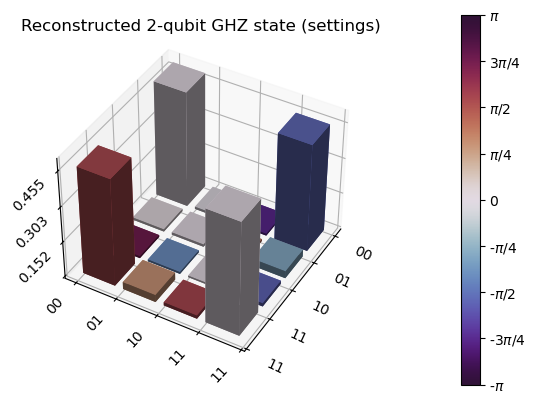

Fidelity 0.9732678151434817


In [39]:
rho_measured = maxlik.model_density_matrix()
dmt.plot_density_matrix_3D(rho_measured, ticks_reduction_factor=1, title='Reconstructed 2-qubit GHZ state (settings)')

psi = np.array([1/np.sqrt(2),0,0,1j/np.sqrt(2)])
rho_target = np.outer(psi, np.conj(psi))

print('Fidelity',dmt.fidelity(rho_measured, rho_target))

### The tQST approach

In [30]:
d=2
N=2
ect_tomo = ect.ECTtomography(d, N, verbose=True)

Setting up ECT tomography of 2 qudits (d=2)
Setting up a qudit with d= 2
Got 1 single-qudit real observables
and 1 elements of the maximum abelian subgroup


Provide the measured diagonal and calculate the threshold

In [31]:
diagonal = np.array([3708,77,51,3642]) # HH, HV, VH, HH
threshold = dmt.gini_index(diagonal)

Get the tQST projectors

In [32]:
projs_tQST, names_tQST = ect_tomo.tQST_projectors(diagonal, threshold)

Off-diagonal projectors to be measured given the provided diagonal and threshold:
+-------------+------------------+---------------+
|   Element   |    Projector     | Standard form |
+-------------+------------------+---------------+
| (0, 3, 'r') | ('X0.1', 'X0.1') |      |DD>     |
| (0, 3, 'i') | ('Y0.1', 'X0.1') |      |RD>     |
+-------------+------------------+---------------+
Name conventions are as follows:
 * |zn.n> are vectors of zeroes, except at position i where they are 1;
 * |xn.m> and |Xn.m> are the eigenvectors with eigenvalues -1 and 1, respectively, of the SU(d) matrices that have 1 in position nm and mn;
 * |yn.m> and |Yn.m> are the eigenvectors with eigenvalues -1 and 1, respectively, of the SU(d) matrices that have i in position nm and -i at mn.


In [33]:
counts_tQST = np.array([1713, 3686]) # DD RD
for name, count in zip(names_tQST, counts_tQST):
    ect_tomo.add_count(name, count)

Set up the maximum likelihood estimation and reconstruct the matrix; we use a g5 model for a faster running, and a pool of 100 random starting point for the minimization

In [36]:
maxlik = ml.Maximum_likelihood_tomography([d]*N, model=ml.model_g5, model_params=N)
maxlik.set_counts(*ect_tomo.get_counts()) # Set the projectors ansd counts to what we have measured
maxlik.minimize_pool_mt(100)

Tomography of [2, 2] using Garbe5 model with 16 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}


100%|███████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 23008.38it/s]


  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.8627772323802284e-15
        x: [-5.387e+01 -5.988e+00 ...  1.122e+00 -3.115e+01]
      nit: 18
      jac: [-8.203e-09 -1.012e-08 ...  7.657e-09  2.873e-08]
     nfev: 22
     njev: 22
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>

Get the reconstructed matrix, plot it and calculate the fidelity wrt the target density matrix

['', '0.152', '0.303', '0.455', '0.606']


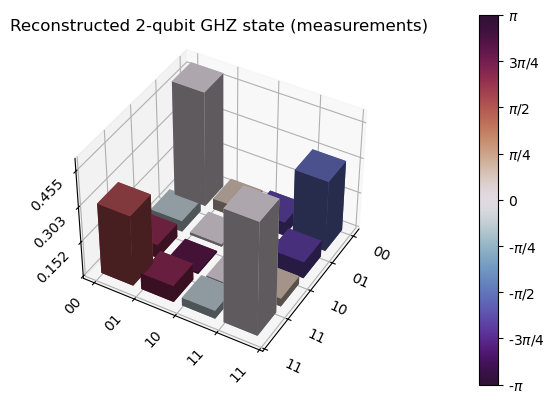

Fidelity 0.8911834632449516


In [37]:
rho_measured = maxlik.model_density_matrix()
dmt.plot_density_matrix_3D(rho_measured, ticks_reduction_factor=1, title='Reconstructed 2-qubit GHZ state (measurements)')

psi = np.array([1/np.sqrt(2),0,0,1j/np.sqrt(2)])
rho_target = np.outer(psi, np.conj(psi))

print('Fidelity',dmt.fidelity(rho_measured, rho_target))